<a href="https://colab.research.google.com/github/ZahraReyhanian/DGM/blob/main/RealNVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import neccesary libraries

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
import torch.nn.init as init
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.distributions.multivariate_normal import MultivariateNormal
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Batch size
batch_size = 100

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Prepare dataset

In [ ]:
def get_mnist_data(device, batch_size):
    preprocess = transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)

    # Create pre-processed training and test sets
    X_train = train_loader.dataset.train_data.to(device).reshape(-1, 784).float() / 255
    y_train = train_loader.dataset.train_labels.to(device)
    X_test = test_loader.dataset.test_data.to(device).reshape(-1, 784).float() / 255
    y_test = test_loader.dataset.test_labels.to(device)

    return train_loader, test_loader

train_loader, test_loader = get_mnist_data(device, batch_size)
train_loader

100%|██████████| 9912422/9912422 [00:00<00:00, 80403239.75it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44017330.60it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20848958.43it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13229533.87it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Coupling Layer Class

In [ ]:
class CouplingLayer(nn.Module):
    """
    A couplingLayer layer.

    """
    def __init__(self, input_dim, hidden_dim):
      super(CouplingLayer, self).__init__()
      self.input_dim = input_dim
      self.hidden_dim = hidden_dim

      ## layers used to compute scale in affine transformation
      self.scale_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
      self.scale_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
      self.scale_fc3 = nn.Linear(self.hidden_dim, self.input_dim)


      ## layers used to compute translation in affine transformation
      self.translation_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
      self.translation_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
      self.translation_fc3 = nn.Linear(self.hidden_dim, self.input_dim)

    def _compute_scale(self, x):
        ## compute scaling factor
        s = torch.relu(self.scale_fc1(x))
        s = torch.relu(self.scale_fc2(s))
        s = torch.relu(self.scale_fc3(s))
        return s

    def _compute_translation(self, x):
        ## compute translation
        t = torch.relu(self.translation_fc1(x))
        t = torch.relu(self.translation_fc2(t))
        t = self.translation_fc3(t)
        return t

    def forward(self, x):
      '''
        forward step:
          This method divides the input into two equal parts.
          The formula is like the formula 4, 5 of RealNVP paper.

        input: x
        output: y, log of determinant of Jacobian matrix

      '''
      x_a, x_b = x.chunk(2, dim=1)

      s = self._compute_scale(x_a)
      t = self._compute_translation(x_a)

      y_a = x_a
      y_b = torch.exp(s).mul(x_b) + t

      logdet = torch.sum(s, -1)

      return torch.cat([y_a, y_b], dim=1), logdet

    def inverse(self, y):
      '''
        inverse step:
          This method divides the input into two equal parts.
          The formula is like the formula 8 of RealNVP paper.

        input: y
        output: x, log of determinant of Jacobian matrix

      '''
      y_a, y_b = y.chunk(2, dim=1)

      s = self._compute_scale(y_a)
      t = self._compute_translation(y_a)

      x_a = y_a
      x_b = (y_b - t).mul(torch.exp(-s))

      logdet = torch.sum(-s, -1)

      return torch.cat([x_a, x_b], dim=1), logdet

## Permutation Class

In [ ]:
class Permutation(nn.Module):
    """
    A permutation layer.
    The main work in this layer is to apply torch.flip method on given data
    which reverses the order of an n-D tensor along [0,1] axis in dims.

    """
    def __init__(self):
        super().__init__()
        self.permutation = torch.flip

    def forward(self, x):
        return self.permutation(x, [0,1]), 0

    def inverse(self, x):
        return self.permutation(x, [0,1]), 0

## RealNVP Class

In [ ]:
class RealNVP(nn.Module):
    """
    A simple RealNVP class based on "DENSITY ESTIMATION USING REAL NVP" paper
    """
    def __init__(self, input_dim, hidden_dim, flow_n=4):
      super(RealNVP, self).__init__()
      self.input_dim = input_dim
      self.hidden_dim = hidden_dim
      self.flow_n = flow_n

      # in default we have 4 pair of coupling layer and permutation
      # they're saved in layers variable that is a ModuleList.
      # This is out model parameter that must be learnd and optimized.
      self.layers = nn.ModuleList()
      for i in range(flow_n):
        self.layers.append(CouplingLayer(self.input_dim, self.hidden_dim))
        self.layers.append(Permutation())

    def forward(self, x):
        '''
          implement forward method of each layer in self.layers and
          compute total log of Jacobian determinant

          input: x
          output: y,  total log of Jacobian determinant
        '''
        y = x
        logp_tot = 0
        for i in range(self.flow_n):
            y, logdet = self.layers[i](y)
            logp_tot = logp_tot + logdet


        return y, logp_tot


    def inverse(self, y):
        '''
          implement inverse method of each layer in self.layers and
          compute total log of Jacobian determinant

          input: y
          output: x,  total log of Jacobian determinant
        '''
        x = y
        logp_tot = 0
        for i in range(self.flow_n-1,-1,-1):
            x, logdet = self.layers[i].inverse(x)
            logp_tot = logp_tot + logdet

        return x, logp_tot


## Train Model

In [ ]:
num_epochs = 50
learning_rate = 0.001
input_dim = 28*14
hidden_dim = 120

In [ ]:
model = RealNVP(input_dim, hidden_dim)

# Choose Adam Optimizer, lr = learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x = torch.bernoulli(x.to(device).reshape(x.size(0), -1))
        y = y.new(np.eye(10)[y]).to(device).float()

        # Forward pass and loss
        z, logdet = model.inverse(x)
        loss = torch.log(z.new_tensor([2*math.pi])) + torch.mean(torch.sum(0.5*z**2, -1) - logdet)

        # Backward pass and update
        loss.backward()
        optimizer.step()

        # zero grad before new step
        optimizer.zero_grad()
        epoch_loss += loss.item()

    if (epoch+1) % 1 == 0:
        print(f'epoch: {epoch+1}, train loss = {float(epoch_loss/(batch_idx+1)):.4f}')
        train_losses.append(float(epoch_loss/(batch_idx+1)))

        with torch.no_grad():
            test_loss = 0

            for batch_idx2, (xt, _) in enumerate(test_loader):
                xt = torch.bernoulli(xt.to(device).reshape(xt.size(0), -1))

                z, logdet = model.inverse(xt)
                loss = torch.log(z.new_tensor([2*math.pi])) + torch.mean(torch.sum(0.5*z**2, -1) - logdet)

                test_loss += loss.item()

            print(f'epoch: {epoch+1}, test loss = {float(test_loss/(batch_idx2+1)):.4f}')
            test_losses.append(float(test_loss/(batch_idx2+1)))

epoch: 1, train loss = 24.6853
epoch: 1, test loss = 20.3637
epoch: 2, train loss = 19.5413
epoch: 2, test loss = 18.7926
epoch: 3, train loss = 18.4491
epoch: 3, test loss = 18.0395
epoch: 4, train loss = 17.8827
epoch: 4, test loss = 17.6410
epoch: 5, train loss = 17.4994
epoch: 5, test loss = 17.3198
epoch: 6, train loss = 17.2056
epoch: 6, test loss = 17.0606
epoch: 7, train loss = 16.9809
epoch: 7, test loss = 16.8726
epoch: 8, train loss = 16.8120
epoch: 8, test loss = 16.7062
epoch: 9, train loss = 16.6835
epoch: 9, test loss = 16.6045
epoch: 10, train loss = 16.5723
epoch: 10, test loss = 16.4832
epoch: 11, train loss = 16.4562
epoch: 11, test loss = 16.4605
epoch: 12, train loss = 16.3867
epoch: 12, test loss = 16.3689
epoch: 13, train loss = 16.3238
epoch: 13, test loss = 16.2883
epoch: 14, train loss = 16.2707
epoch: 14, test loss = 16.3242
epoch: 15, train loss = 16.2008
epoch: 15, test loss = 16.2268
epoch: 16, train loss = 16.1648
epoch: 16, test loss = 16.1652
epoch: 17,

## Plot Train and Test Loss

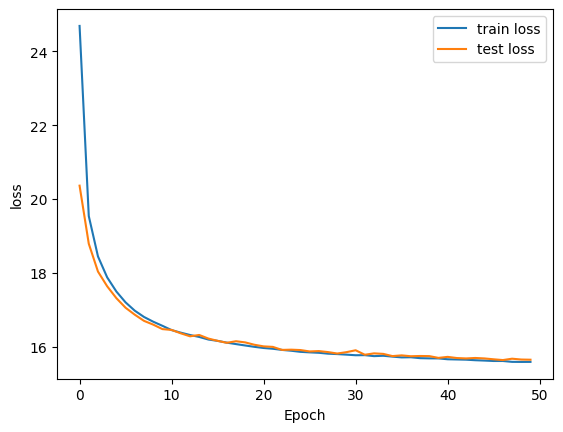

In [ ]:
plt.plot(range(num_epochs), train_losses, label="train loss")
plt.plot(range(num_epochs), test_losses, label="test loss")
plt.ylabel("loss")
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Generate random pictures

In [ ]:
# Generate a new random seed
z = torch.rand(16, 28*28)

# Generate a new fake image
z = torch.bernoulli(z.to(device).reshape(z.size(0), -1))
fake_image, _ = model(z)

In [ ]:
t = fake_image.detach().numpy().reshape(16,28,28)

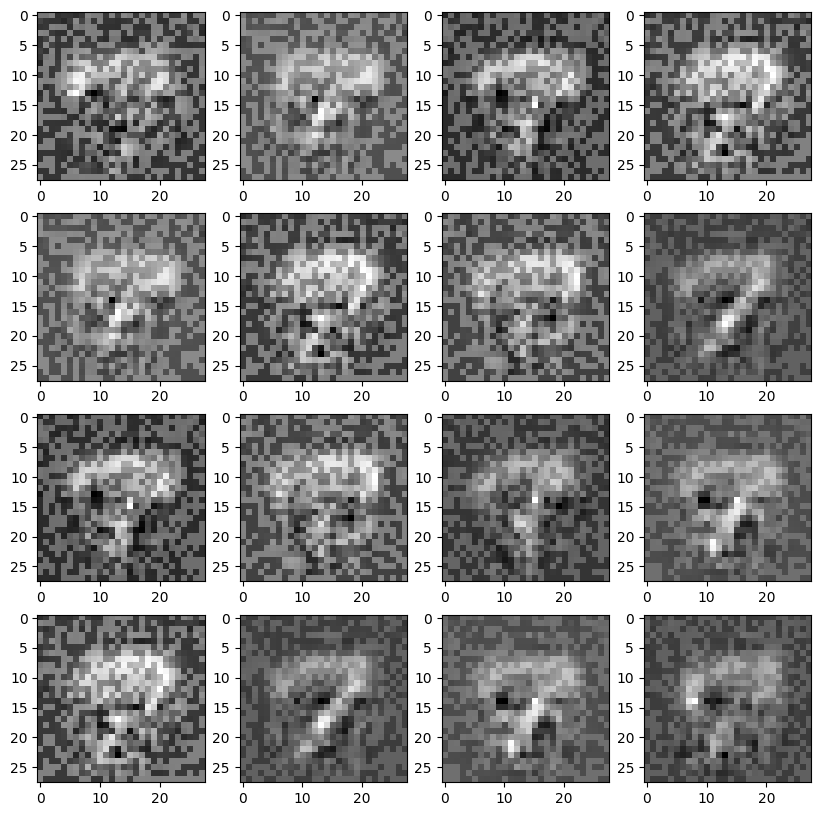

In [ ]:
f, axis = plt.subplots(4, 4)
f.set_figheight(10)
f.set_figwidth(10)

for i in range(4):
  for j in range(4):
    pic = (t[(i+1)*(j+1)-1])
    axis[i,j].imshow(pic, cmap='gray')